In [1]:
from wolpertinger_net import *
sess = tf.Session(config=tf.ConfigProto(device_count = {'GPU': 0}))
net = WolpertingerNet(sess, seq_len=32, lr=0.0001)
%load_ext line_profiler

In [2]:
import os
import pickle

data = {}
for f in os.listdir('data/genes'):
    data[f[:-2]] = pickle.load(open('data/genes/' + f, 'rb'), encoding='latin1')
    
labels = [x for x in data]
testing = ['LCE6A','RCOR3','KLHL20','GPR137B','USH2A','SMYD3',
           'CNIH3','CFHR2','WDYHV1','OPN3','TNN',
           'CAMK1G','LENEP','CYB5R1','EPHX1']
training = [x for x in labels if x not in testing]

val = []
tran = []
tran_times = []
val_times = []

In [3]:
disp = 8
print('Training:')
for x in training[:disp]:
    print(x, len(data[x]))
print(f'... {len(training) - disp} more')
print()
print('Validation:')
for x in testing[:disp]:
    print(x, len(data[x]))
print(f'... {len(testing) - disp} more')

Training:
HHAT 146
RASAL2 323
CKS1B 14
PEA15 36
SPRTN 119
PEX11B 78
OR6Y1 99
DPYS 135
... 927 more

Validation:
LCE6A 30
RCOR3 145
KLHL20 142
GPR137B 93
USH2A 1225
SMYD3 81
CNIH3 26
CFHR2 45
... 7 more


In [4]:
def get_time_top3(dataset):
    test_data = data[random.choice(dataset)]

    s, a, ns, r = net.path([(dna_vec(a), b) for a, b in test_data])
    top3 = sorted(test_data, key=lambda x: x[1])[-3:]

    for i, (state, action, reward) in enumerate(zip(s, a, r)):
        best_seen = state[-1]# max(state, key=lambda x: x[1])
        if vec_dna(best_seen[0]) in [x[0] for x in top3]:
            return i
    return 20


In [ ]:
from tqdm import trange
import random 
for i in trange(2000):
    gene = random.choice(training)
    samples = [(dna_vec(a), b) for a, b in data[gene]]
    #%lprun -f SeqNet.multi_path net.train(samples, 10)
    tran.append(net.train(samples, 5, 16))
    gene = random.choice(testing)
    samples = [(dna_vec(a), b) for a, b in data[gene]]
    tran_times.append(get_time_top3(training))
    val_times.append(get_time_top3(testing))
    if i % 2 + 1:
        val.append(net.evaluate(samples, 5))
    else:
        val.append(val[-1])

In [40]:
net.sess.run(net.eps)

0.665151

In [7]:
# Save weights

saver = tf.train.Saver()
saver.save(net.sess, 'results/model.ckpt')

'results/model.ckpt'

In [39]:
# Load weights

saver = tf.train.Saver()
saver.restore(net.sess, 'results/model.ckpt')

INFO:tensorflow:Restoring parameters from results/model.ckpt


In [8]:
# Save training data

pickle.dump(val, open('results/validation.p', 'wb'))
pickle.dump(tran, open('results/training.p', 'wb'))
pickle.dump(tran_times, open('results/tran_times.p', 'wb'))
pickle.dump(val_times, open('results/val_times.p', 'wb'))

In [69]:
import pickle
# Load old data

val = pickle.load(open('results/validation.p', 'rb'))
tran = pickle.load(open('results/training.p', 'rb'))
tran_times = pickle.load(open('results/tran_times.p', 'rb'))
val_times = pickle.load(open('results/val_times.p', 'rb'))

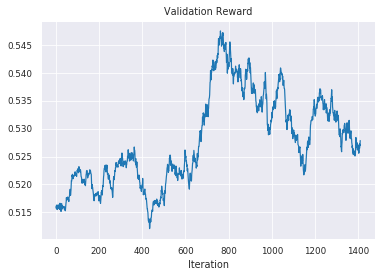

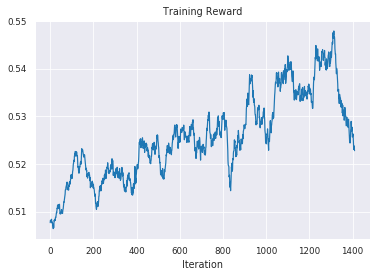

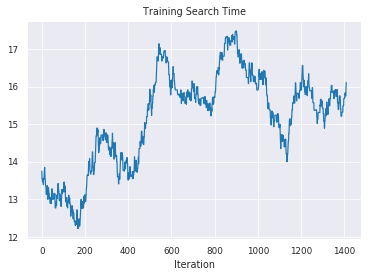

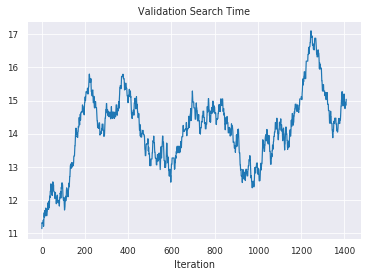

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style('darkgrid')
sns.set_context('paper')

gsmooth = 100

smooth = gsmooth
plt.title('Validation Reward')
plt.xlabel('Iteration')
plt.plot(np.convolve(val, [1 / smooth] * smooth)[smooth:-smooth])
plt.savefig('results/validation.png')
plt.show()

smooth = gsmooth
plt.title('Training Reward')
plt.xlabel('Iteration')
plt.plot(np.convolve(tran, [1 / smooth] * smooth)[smooth:-smooth])
plt.savefig('results/training.png')
plt.show()

smooth = gsmooth
plt.title('Training Search Time')
plt.xlabel('Iteration')
plt.plot(np.convolve(tran_times, [1 / smooth] * smooth)[smooth:-smooth])
plt.savefig('results/tran_time.png')
plt.show()

smooth = gsmooth
plt.title('Validation Search Time')
plt.xlabel('Iteration')
plt.plot(np.convolve(val_times, [1 / smooth] * smooth)[smooth:-smooth])
plt.savefig('results/val_time.png')
plt.show()

In [64]:
test_data = data[random.choice(testing)]
print('Avg rate:', np.array([i[1] for i in test_data]).mean())
s, a, ns, r = net.path([(dna_vec(a), b) for a, b in test_data])
print('Avg reward:', np.array(r).mean())
print()
top3 = sorted(test_data, key=lambda x: x[1])[-3:]
done = 0

print('top 3')
for x in top3:
    print(*x)

print()
print('state\t\t\t\t\t', 'rate\t\t', 'action\t\t\t\t\t', 'reward\t\t')
for i, (state, action, reward) in enumerate(zip(s, a, r)):
    best_seen = state[0]# max(state, key=lambda x: x[1])
    if vec_dna(best_seen[0]) in [x[0] for x in top3] and not done:
        #times.append(i)
        done = 1
    print(vec_dna(best_seen[0]), '\t', '%.5f' % best_seen[1], '\t', vec_dna(action), '\t', '%.5f' % reward)

Avg rate: 0.5095424572208203
Avg reward: 0.49869317972828375

top 3
GCAGCCAAGAAATAAGAAAAGCACAAAGGAGG 0.6952423360545783
CCATAGCAATGGGCTATGACACCCAGGGGCAC 0.7705139193565226
AGTCCACAGTGCAGCCTAGTCCGTGTACGTCC 0.8236458623483799

state					 rate		 action					 reward		
CAGCCCACGGTGTCCCACACCCAGCCGTTCCT 	 0.58020 	 ATTCTAATGGGCAATTTTTGCTCCCGAGGACT 	 0.48632
CAGCCCACGGTGTCCCACACCCAGCCGTTCCT 	 0.58020 	 ATTCTAATGGGCAATTTTTCCTCCCGAGGACT 	 0.48632
CAGCCCACGGTGTCCCACACCCAGCCGTTCCT 	 0.58020 	 ATTCTAATGGGCAATTTTTGCTCCCGAGGACT 	 0.54888
CAGCCCACGGTGTCCCACACCCAGCCGTTCCT 	 0.58020 	 ATTCTAATGGGCAATTTTTGCTCCCGAGGACT 	 0.48632
CAGCCCACGGTGTCCCACACCCAGCCGTTCCT 	 0.58020 	 CTTCTAATGGGCAATTTTTGCTCCCGAGGACT 	 0.36348
CAGCCCACGGTGTCCCACACCCAGCCGTTCCT 	 0.58020 	 ATTCTAATGGGCAATTTTTGCTCCCGAGGACT 	 0.54888
CAGCCCACGGTGTCCCACACCCAGCCGTTCCT 	 0.58020 	 TTTCTAATGGGCAATTTTTGCTCCCGAGGACT 	 0.43894
CAGCCCACGGTGTCCCACACCCAGCCGTTCCT 	 0.58020 	 ATTCTAATGGGCAATTTTTGCTCCCGAGGACT 	 0.54888
CAGCCCACGGTGTCCCACACCCAGCCGTTCCT